# Preprocessing + feature extraction

This notebook contains the followiong:
    - LUNG hu unit pre processing...

Some setup...

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import tensorflow as tf
import sys
#sys.path.append("../")

import vgg16
import utils
import os
import csv
from itertools import islice
import matplotlib.pyplot as plt

In [33]:
def get_lung_dataset_batch(images_directory, labels_file, lung_count, batch_num):
    if not hasattr(get_lung_dataset_batch, 'labels_by_name'):
        # read labels from csv
        get_lung_dataset_batch.labels_by_name = {}
        with open(labels_file, 'rb') as csv_labels:
            labels_reader = csv.reader(csv_labels)
            for row in islice(labels_reader, 1, None):
                get_lung_dataset_batch.labels_by_name[row[0]] = int(row[1])
            
    train_images = []
    train_labels = []
    #test_images = []
    #for _, _, files in os.walk(lungs_dir):
    #for f in files[batch_num*lung_count:(batch_num+1)*lung_count]:
    for lung_id in get_lung_dataset_batch.labels_by_name.keys()[batch_num*lung_count:(batch_num+1)*lung_count]:
        f = lung_id + '.npy'
        lung_img = np.load(lungs_dir + '/' + f)
        for ct_slice in lung_img:
            data_point = np.repeat([ct_slice], 3, axis=0)\
                .transpose(1, 2, 0)[1:-2,1:-2,:]
            #lung_id = f.split('.')[0]
            #if lung_id in labels_by_name:
            train_images.append(data_point)
            train_labels.append(get_lung_dataset_batch.labels_by_name[lung_id])
            #else:
                #test_images.append(data_point)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    #test_images = np.array(test_images)
    return {
        'X_train': train_images,
        'y_train': train_labels#,
        #'X_test': test_images
    }

In [34]:
# try getting a batch of the lung data

lungs_dir = '../input/3Darrays_stage1_2'
labels_file = '../input/stage1_labels.csv'

data = get_lung_dataset_batch(lungs_dir, labels_file, 5, 0)

print "Training data shape: {}".format(data['X_train'].shape)
print "Training labels shape: {}".format(data['y_train'].shape)
#print "Test data shape: {}".format(data['X_test'].shape)

Training data shape: (300, 224, 224, 3)
Training labels shape: (300,)


# Data exploration

### Note: cylindrical bounds were mapped to -10000.

When we downsample, we use spline interpolation with polynomial degree 3. This is why there are values around -10000 and not exactly at -10000. We will deal with this later...

6006
-14837


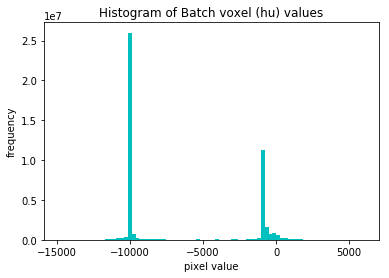

In [35]:
print data['X_train'].max()
print data['X_train'].min()

plt.hist(data['X_train'].flatten(), bins=80, color='c')
plt.xlabel("pixel value")
plt.ylabel("frequency")
plt.title('Histogram of Batch voxel (hu) values')

plt.show()

Lets look at the two peaks in our histogram and see where these pixels live...

(White represent pixels in the desired range)
HU Units

0 := water

\-1000 := air

700-900 := lung

10-50 := soft tissue

(224, 224)
 > -600


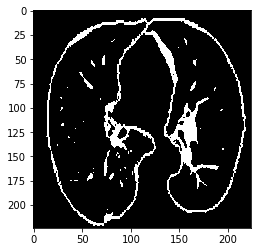

< -600


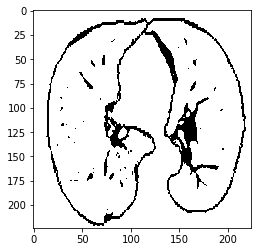

Lung slice


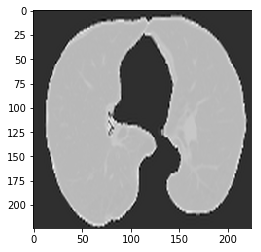

In [36]:
img = data['X_train'][30,:,:,0]
print img.shape
zero_center = img > -600
notzero_center = img < -600
print " > -600"
plt.imshow(zero_center, cmap=plt.cm.gray)
plt.show()
print "< -600"
plt.imshow(notzero_center, cmap=plt.cm.gray)
plt.show()
print "Lung slice"
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [11]:
def image_mask(img, low, high):
    return (img <= high) * (img >= low)
def show_img(img):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
def show_img_t(img, low, high):
    mask = image_mask(img, low, high)
    plt.imshow(img*mask, cmap=plt.cm.gray)
    plt.show()

Morphological mask of the image to get lung tissue

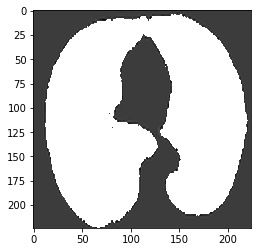

In [38]:
show_img_t(img, -20000, -9000)

-1500 - -1350


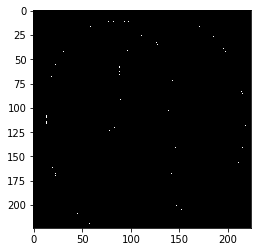

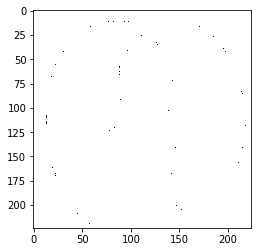

-1350 - -1200


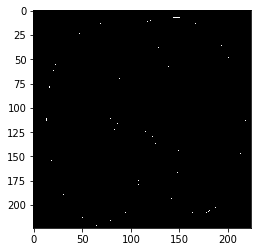

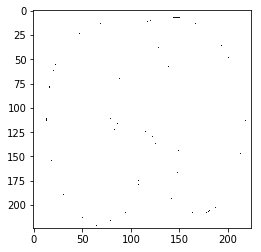

-1200 - -1050


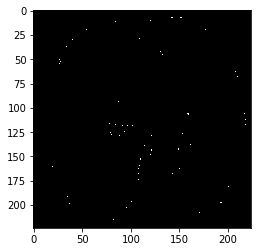

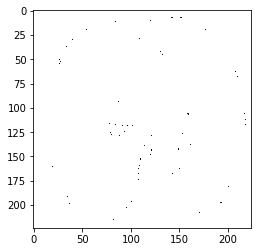

-1050 - -900


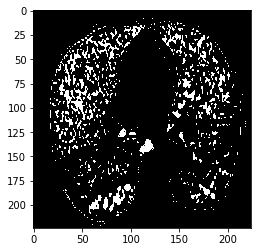

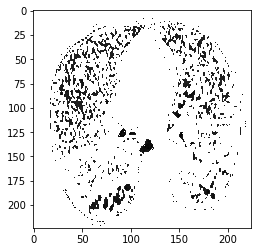

-900 - -750


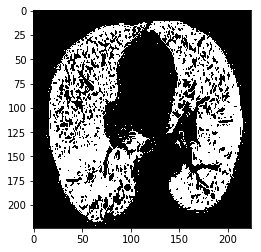

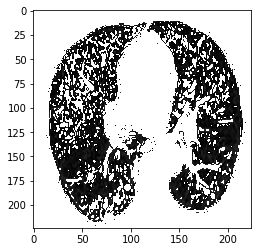

-750 - -600


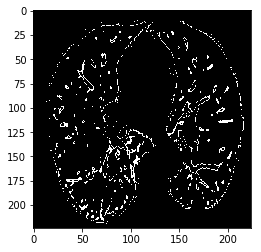

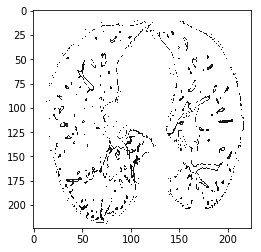

-600 - -450


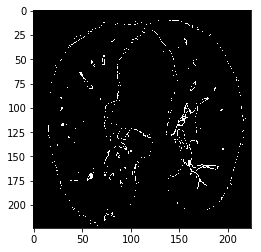

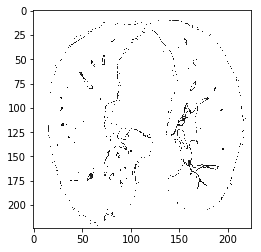

-450 - -300


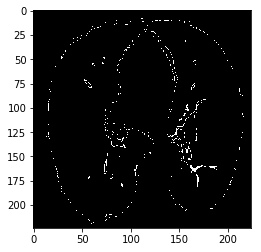

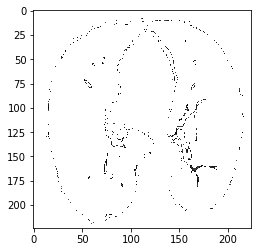

-300 - -150


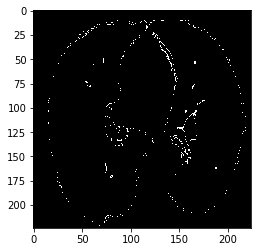

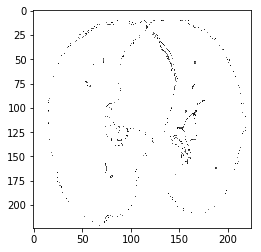

-150 - 0


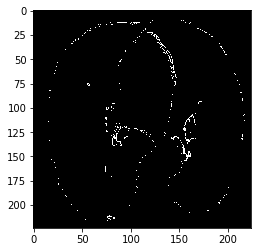

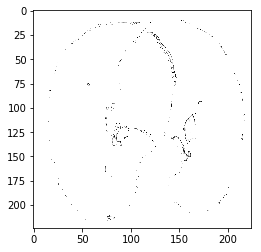

0 - 150


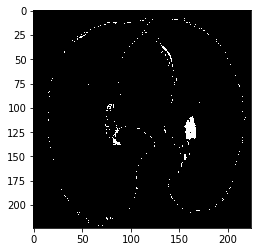

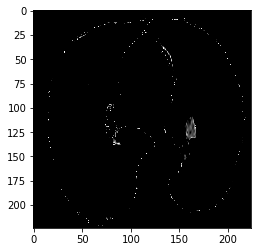

150 - 300


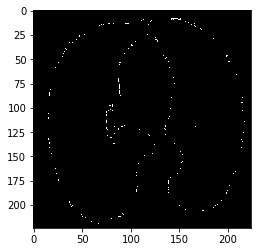

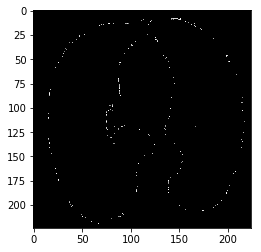

300 - 450


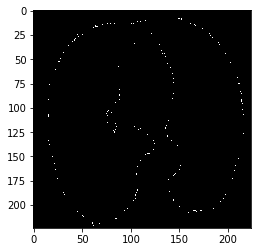

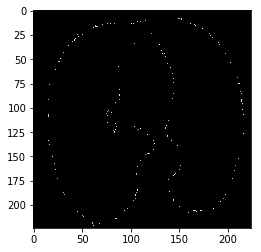

450 - 600


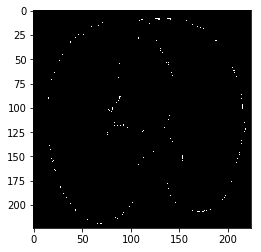

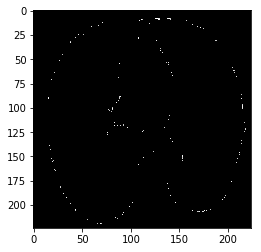

600 - 750


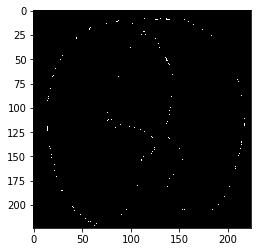

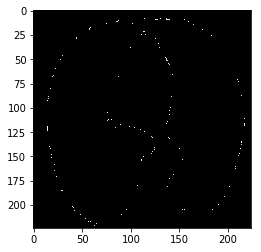

750 - 900


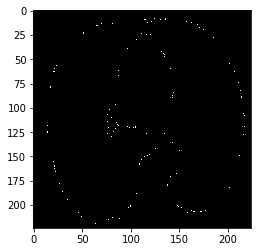

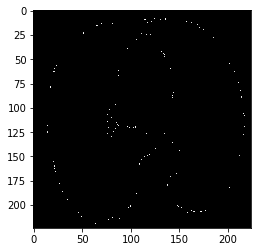

900 - 1050


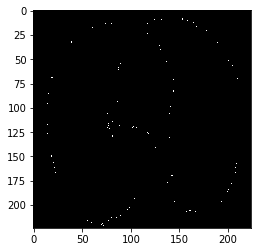

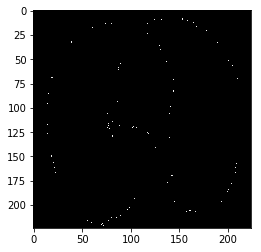

1050 - 1200


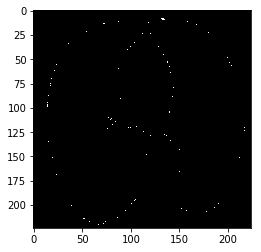

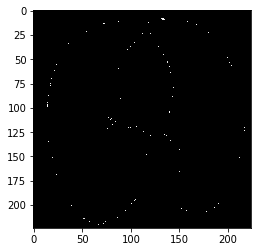

1200 - 1350


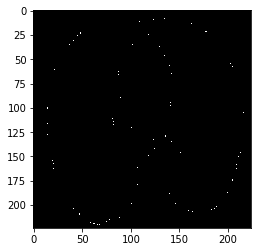

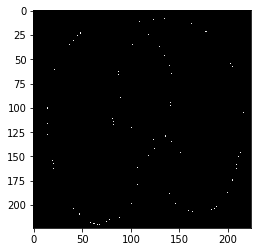

1350 - 1500


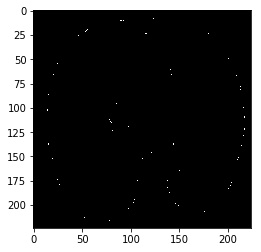

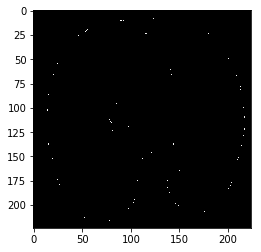

In [39]:
for band in xrange(-1500, 1500, 150):
    print "{} - {}".format(band, band + 150)
    show_img(image_mask(img, band, band + 150))
    show_img_t(img, band, band + 150)

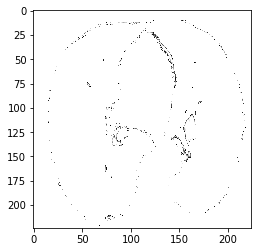

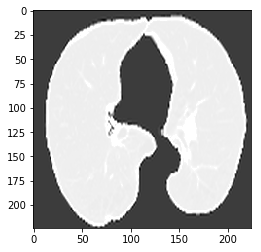

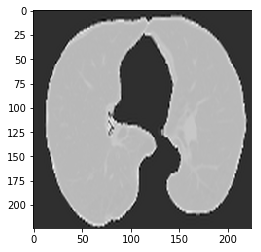

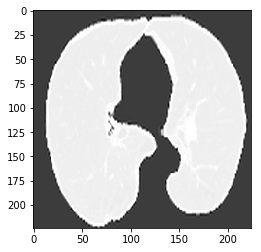

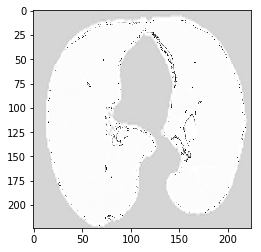

In [41]:
mask_high = (img > -200) * (img < -5)
mask_low = img < -375

img_high = img * mask_high
img_low = img * mask_low

show_img(img_high)
show_img(img_low)
show_img(img)

show_img(img_low + (img_high - mask_high * 300))
show_img(img_low - (mask_high * -300)*img)

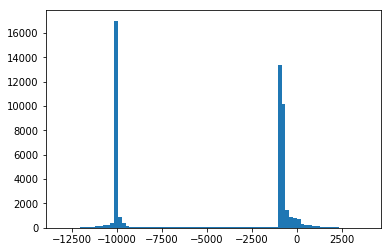

In [42]:
plt.hist(img.flatten(), bins=80)
plt.show()

### Looking at raw slice data

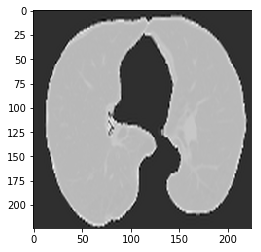

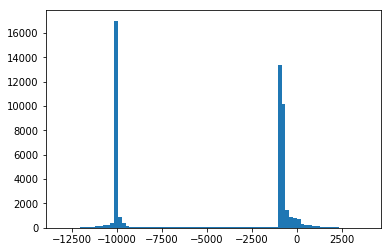

In [43]:
img = data['X_train'][30,:,:,0]
plt.imshow(img, cmap=plt.cm.gray)
plt.show()
plt.hist(img.flatten(), bins=80)
plt.show()


### Increase image contrast by moving masked values closer to air

Moving masked pixels to -1500 seems to be qualitatively ok....

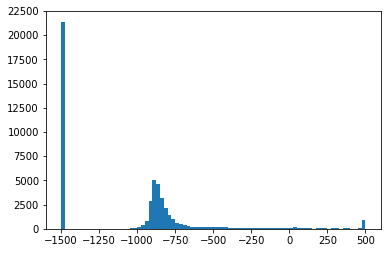

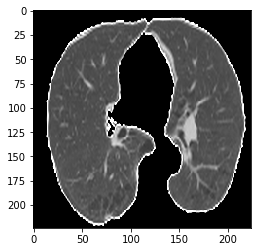

In [44]:
HU_MIN = -1500
HU_MAX = 500
data = get_lung_dataset_batch(lungs_dir, labels_file, 5, 0)


img2 = data['X_train'][30,:,:,0][:]
img2[img2 < HU_MIN] = HU_MIN
img2[img2 > HU_MAX] = HU_MAX
plt.hist(img2.flatten(), bins=80)
plt.show()
plt.imshow(img2, cmap=plt.cm.gray)
plt.show()

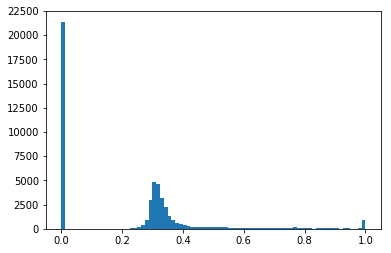

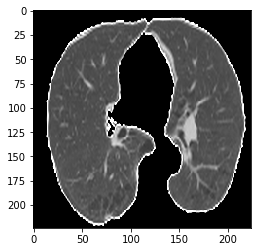

In [45]:
# extract vgg features from the image data

batch_size = 1
weights_file = './vgg16.npy'

train_size = 1397
num_batches = train_size / batch_size

def scale(lung, low, high):
    lung -= low
    return lung / float(high-low)
    

def minibatch(batch):
    for item in batch['X_train']:
        yield item[None,:,:,:]
    return
scaled = scale(img2, HU_MIN, HU_MAX)
plt.hist(scaled.flatten(), bins=80)
plt.show()
show_img(scaled)


In [49]:
print sys.path

['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/root/.ipython', '../src/', '../src/', ':../src/', '../', '../', '../']


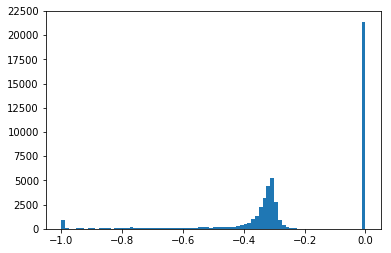

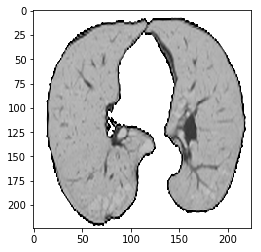

In [57]:
sys.path.append('../src')
from lung_utils import *

data = get_lung_dataset_batch(lungs_dir, labels_file, 5, 0)
img = data['X_train'][30,:,:,0][:]
processed = hu_to_visual_features(img, HU_MIN, HU_MAX)
plt.hist(processed.flatten(), bins=80)
plt.show()
show_img(processed)

In [ ]:

gpu_feats = None
cpu_feats = None
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [60, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            #batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            feed_dict = {images: batch_data['X_train']}
            batch_features = sess.run(vgg.pool5, feed_dict=feed_dict)
            cpu_feats = batch_features
            print batch_features.shape

with tf.device('/gpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            #feed_dict = {images: batch_data['X_train']}
            #batch_features = sess.run(vgg.pool5, feed_dict=feed_dict)
            gpu_feats = batch_features
            print batch_features.shape
            
print np.sum(np.square(gpu_feats - cpu_feats))

In [ ]:
print np.abs(gpu_feats).mean()
print np.abs(cpu_feats).mean()
print np.abs(cpu_feats - gpu_feats).mean()

abs_diff = np.abs(gpu_feats - cpu_feats)
print "Maximum absolute difference:{}".format(np.max(abs_diff))
eps = 1e-9
percent_diff = abs_diff / (np.abs(cpu_feats) + eps)
print "Maximum % difference: {}".format(np.max(percent_diff))

In [5]:
ls ../input

3Darrays_stage1_2/  3Darrays_visual_test/  stage1_labels.csv.zip
3Darrays_visual/    stage1_labels.csv


In [26]:
### Look at images dumped hu_to_visual to check...
import os
import numpy as np
INPUT_FOLDER = '../input/3Darrays_visual_test/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
lung_files = [os.path.splitext(f)[0] for f in os.listdir(INPUT_FOLDER)]
print lung_files[:10]

def lung_to_path(lung_id):
    return INPUT_FOLDER + lung_id + ".npy"
def load_lung(lung_id):
    return np.load(lung_to_path(lung_id))
def get_random_lung():
    random_lung_id = np.random.choice(lung_files, 1)[0]
    return load_lung(random_lung_id), random_lung_id

['008464bb8521d09a42985dd8add3d0d2', '01f1140c8e951e2a921b61c9a7e782c2', '026be5d5e652b6a7488669d884ebe297', '013395589c01aa01f8df81d80fb0e2b8', '026470d51482c93efc18b9803159c960', '0268f3a7a17412178cfb039e71799a80', '006b96310a37b36cccb2ab48d10b49a3', '00edff4f51a893d80dae2d42a7f45ad1', '02801e3bbcc6966cb115a962012c35df', '00cba091fa4ad62cc3200a657aeb957e']


01de8323fa065a8963533c4a86f2f6c1


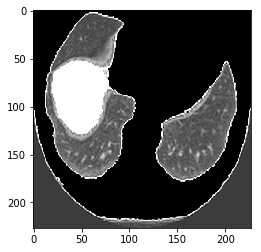

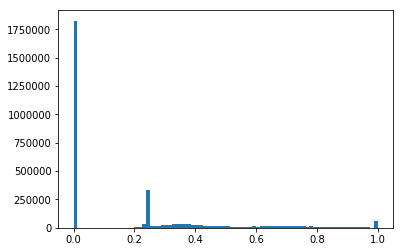

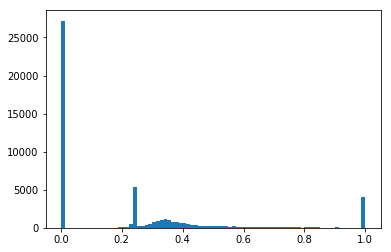

In [40]:
lung, lung_id = get_random_lung()
slice = lung[20]
print lung_id
show_img(slice)
plt.hist(lung.flatten(), bins=80)
plt.show()
plt.hist(slice.flatten(), bins=80)
plt.show()